In [2]:
import pandas as pd
import os
import warnings
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import colorsys
from datetime import timedelta
sns.set_style("whitegrid")

# EDA 

In [3]:
df_org = pd.read_csv('data/synthetical_payments.csv', sep=',')
# convert unxed time
df_org['datetime'] = pd.to_datetime(df_org['transactionTime'], unit='s')

In [4]:
# Duplicates ?
df_org.loc[df_org.duplicated(keep=False)]

,userId,billingCountry,transactionTime,product,price,amount,period,datetime


In [5]:
# Nulls ?
df_org.loc[df_org.isnull().any(axis=1)]

,userId,billingCountry,transactionTime,product,price,amount,period,datetime


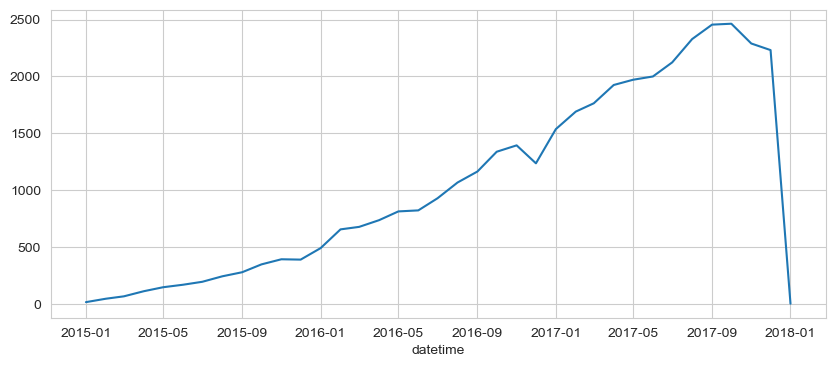

In [6]:
# Weird volume over time?
fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
sns.lineplot(df_org.set_index('datetime').groupby(pd.Grouper(freq='MS')).size(), ax=ax)
# ax = format_ax_date(ax=ax)
plt.show()

> We can drop the records for 2018.

In [7]:
df_org = df_org.loc[df_org['datetime'] < '2018-01-01']

In [8]:
# Any absurd values?

def calculate_column_metrics(df, columns, metrics):
    """
    Calculate specified metrics for given columns in a DataFrame.
    
    :param df: pandas DataFrame
    :param columns: list of column names to analyze
    :param metrics: dict of metric names and corresponding functions
    :return: pandas DataFrame with metrics as columns and original columns as index
    """
    results = {}
    for col in columns:
        col_metrics = {}
        for metric_name, metric_func in metrics.items():
            col_metrics[metric_name] = metric_func(df[col])
        results[col] = col_metrics
    
    return pd.DataFrame(results).T

num_cols = ['price', 'amount']

metrics = {
    'min': np.min,
    'max': np.max,
    'mean': np.mean,
    'median': np.median,
    '1th_percentile': lambda x: np.percentile(x, 1),
    '25th_percentile': lambda x: np.percentile(x, 25),
    '75th_percentile': lambda x: np.percentile(x, 75),
    '90th_percentile': lambda x: np.percentile(x, 90),
    '99th_percentile': lambda x: np.percentile(x, 99),
}

result_df = calculate_column_metrics(df_org, num_cols, metrics)
result_df

,min,max,mean,median,1th_percentile,25th_percentile,75th_percentile,90th_percentile,99th_percentile
price,99.99,399.99,171.434528,199.99,99.99,99.99,199.99,199.99,399.99
amount,49.99,30000.00,411.890196,199.99,49.99,99.99,199.99,1007.90,4031.90


In [9]:
df_org.loc[df_org['amount']>=10000]

,userId,billingCountry,transactionTime,product,price,amount,period,datetime
13010,123321121,United States,1481760000,BUSINESS,399.99,30000.0,1,2016-12-15 00:00:00
37428,123321121,United States,1514163661,BUSINESS,399.99,30000.0,1,2017-12-25 01:01:01


In [10]:
df_org = df_org.loc[~(df_org['amount']>=10000)]

In [11]:
df = df_org.copy()

##### Plot all transactions over time by product

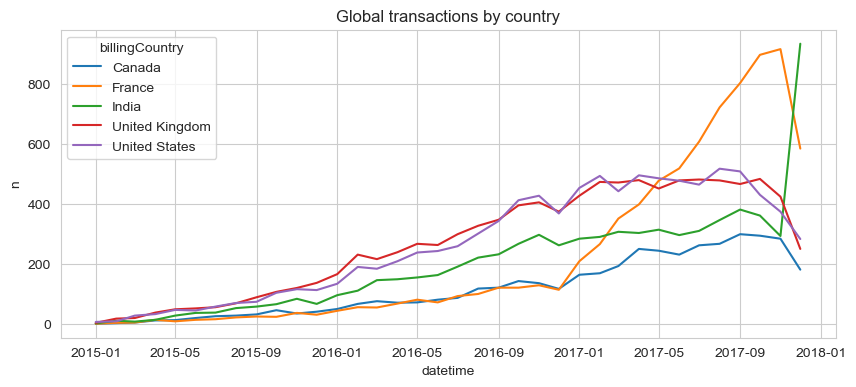

In [12]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
df_plot = df.set_index('datetime').groupby([pd.Grouper(freq='MS'), 'billingCountry']).size().reset_index().rename(columns={0: 'n'})
sns.lineplot(data=df_plot, x='datetime', y='n', ax=ax, hue='billingCountry')
plt.title("Global transactions by country")
plt.show()

##### Plot all transactions over time by product

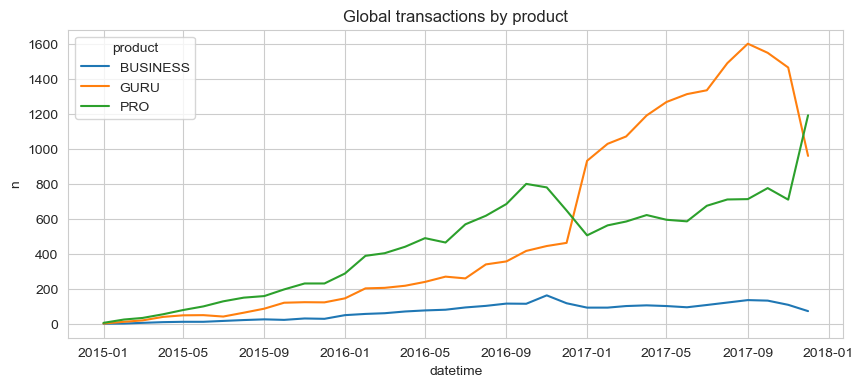

In [13]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
df_plot = df.set_index('datetime').groupby([pd.Grouper(freq='MS'), 'product']).size().reset_index().rename(columns={0: 'n'})
sns.lineplot(data=df_plot, x='datetime', y='n', ax=ax, hue='product')
plt.title("Global transactions by product")
plt.show()

##### Plot all transactions over time by period

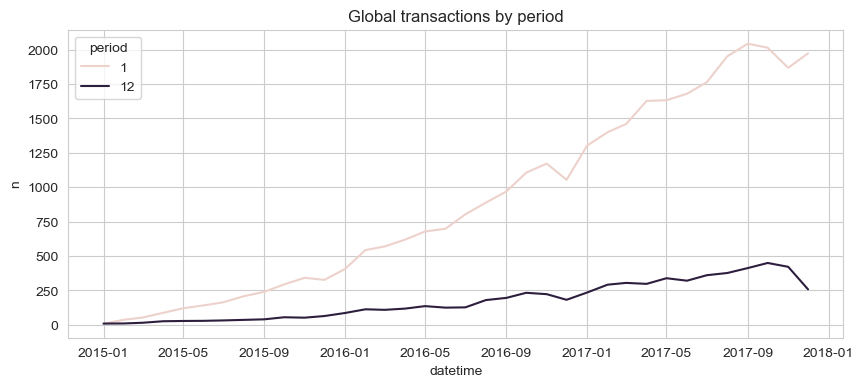

In [14]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
df_plot = df.set_index('datetime').groupby([pd.Grouper(freq='MS'), 'period']).size().reset_index().rename(columns={0: 'n'})
sns.lineplot(data=df_plot, x='datetime', y='n', ax=ax, hue='period')
plt.title("Global transactions by period")
plt.show()

> Data seems decently clean. There is a weird spike of transactions in India at the end of 2017, overlapping with PRO products.

Summary:
- No nulls
- No weird drops of data throughout the years
- Only a couple of outlier values

In [15]:
from src.plot import product_order, color_dict_product, country_order, format_ax_date

##### _How are transactions in each country and by product evolving through time?_

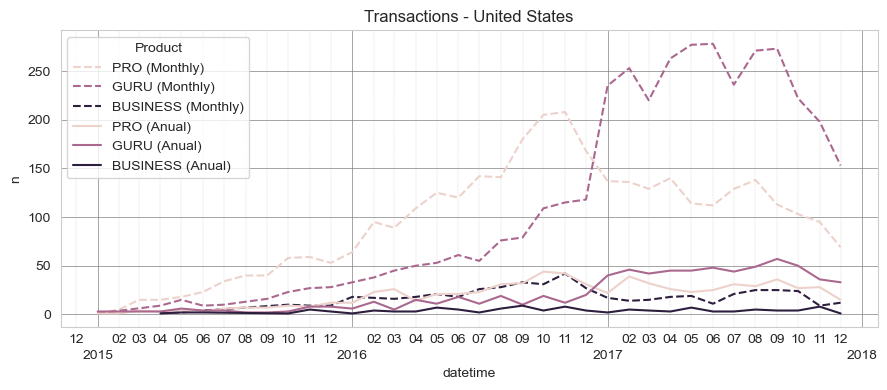

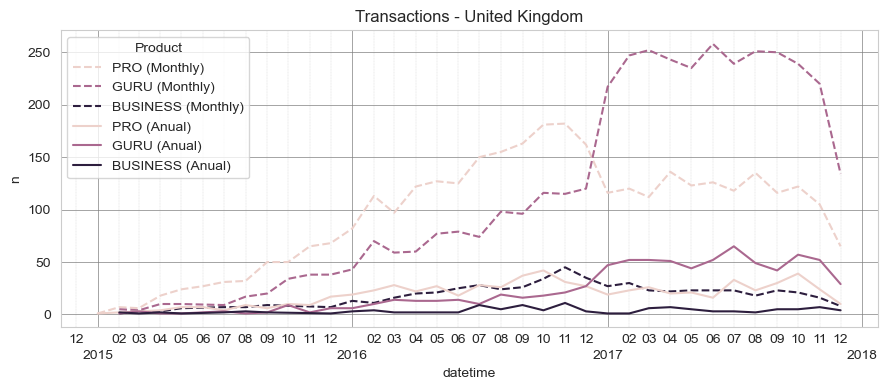

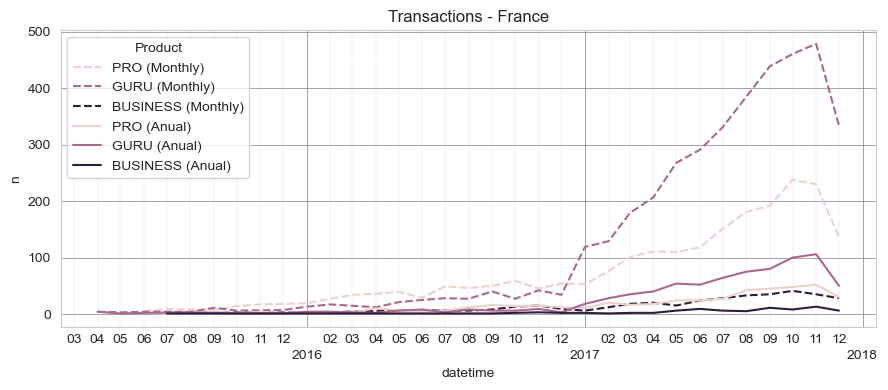

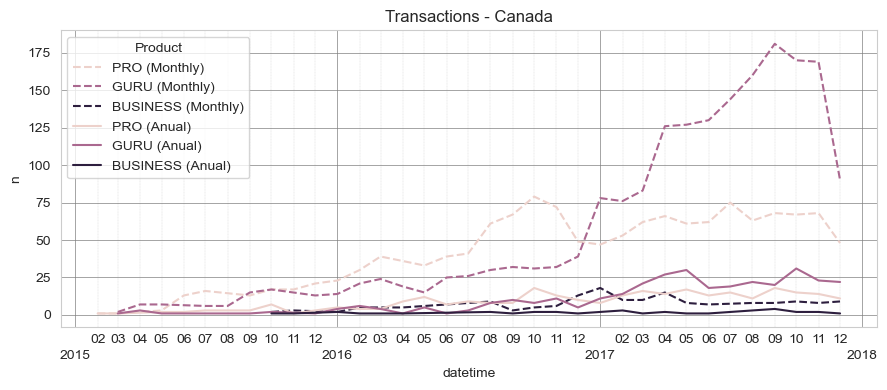

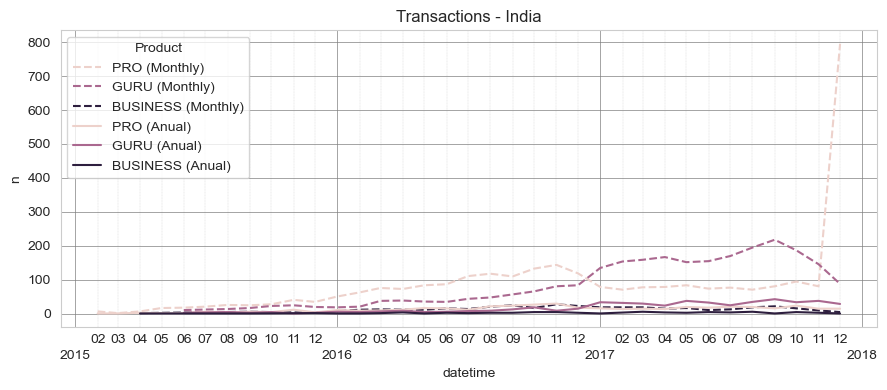

In [16]:
df_time = df.set_index('datetime').groupby([pd.Grouper(freq='MS'), 'billingCountry', 'product', 'period']).size().reset_index().rename(columns={0: 'n'})

df_aux = df_time.loc[df_time['period'] == 1].rename(columns={'n': 'n_monthly'}).drop('period', axis=1)
df_time = df_time.merge(df_aux, on=['datetime', 'billingCountry', 'product'])

df_aux = df_time.loc[df_time['period'] == 12].rename(columns={'n': 'n_anual'}).drop(['period', 'n_monthly'], axis=1)
df_time = df_time.merge(df_aux, on=['datetime', 'billingCountry', 'product'])

df_aux = df.set_index('datetime').groupby([pd.Grouper(freq='MS'), 'billingCountry', 'product']).size().reset_index().rename(columns={0: 'n_tot'})
df_time = df_time.merge(df_aux, on=['datetime', 'billingCountry', 'product'])

df_time['ratio_anual_month'] = df_time['n_anual'] / df_time['n_monthly']

for country in country_order[:]:
    df_aux = df_time.loc[
        (df_time['billingCountry'] == country)
    ]
    
    fig, ax = plt.subplots(figsize=(9,4), dpi=100)
    
    df_plot = df_aux.loc[df_aux['period'] == 1]
    sns.lineplot(data=df_plot, x='datetime', y='n', hue='product', ls='--', palette=color_dict_product, hue_order=product_order, ax=ax)
    
    df_plot = df_aux.loc[df_aux['period'] == 12]
    sns.lineplot(data=df_plot, x='datetime', y='n', hue='product', ls='-', palette=color_dict_product, hue_order=product_order, ax=ax)
        
    ax = format_ax_date(ax)
    plt.title(f"Transactions - {country}")
    
    handles, labels = ax.get_legend_handles_labels()
    labels[:3] = [f"{x} (Monthly)" for x in labels[:3]]
    labels[3:] = [f"{x} (Anual)" for x in labels[3:]]
    ax.legend(handles, labels, title='Product', loc='best')

    plt.tight_layout()
    plt.show()

> As anticipated, we can see that in India there is a huge spike in PRO MONTHLY products at the end of 2017, completely opposite of the trend in the other countries

# Anual to monthly conversion

In [17]:
from src.loader import load_and_clean

In [18]:
df_exploded, _ = load_and_clean()

Loading and cleaning data..
Done.


##### _How do active users in each country and by product change through time?_

In [19]:
df_ref = df_exploded
df_ref['datetime'] = df_ref['mrr_month']

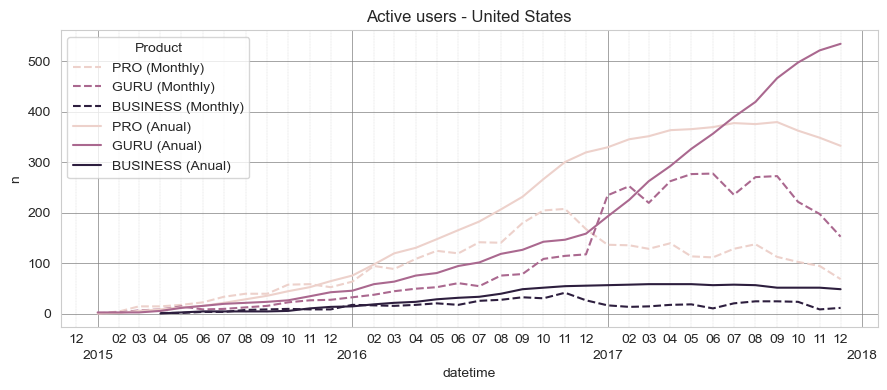

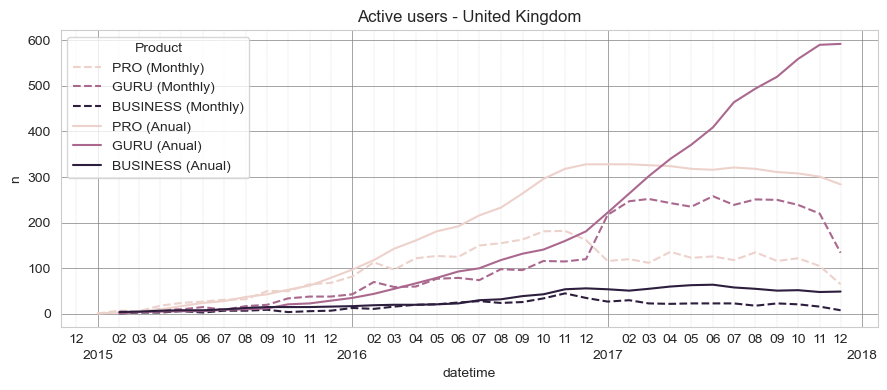

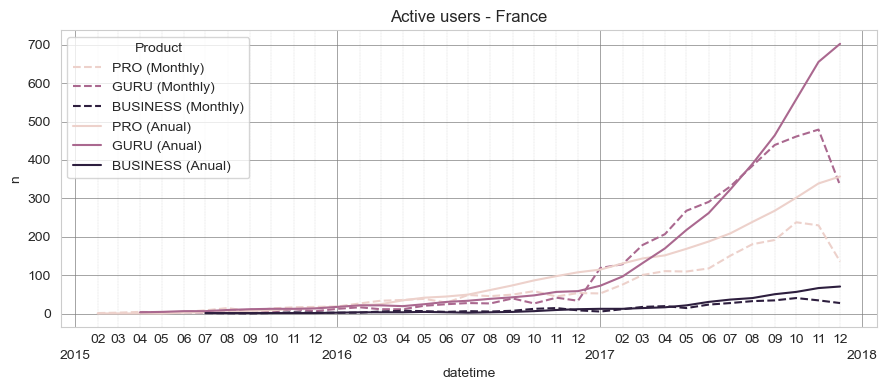

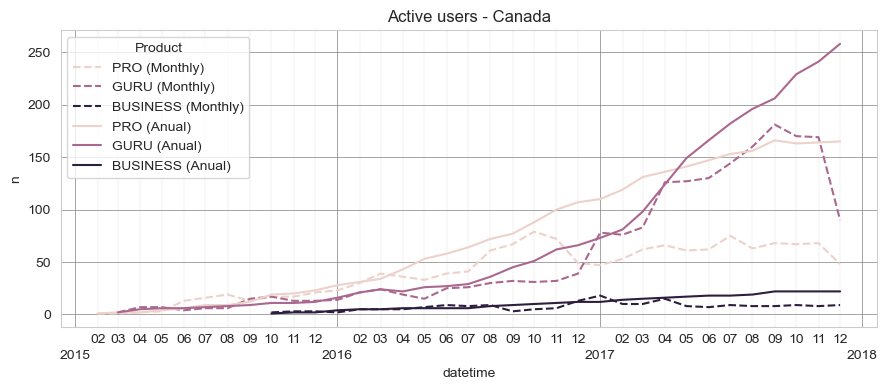

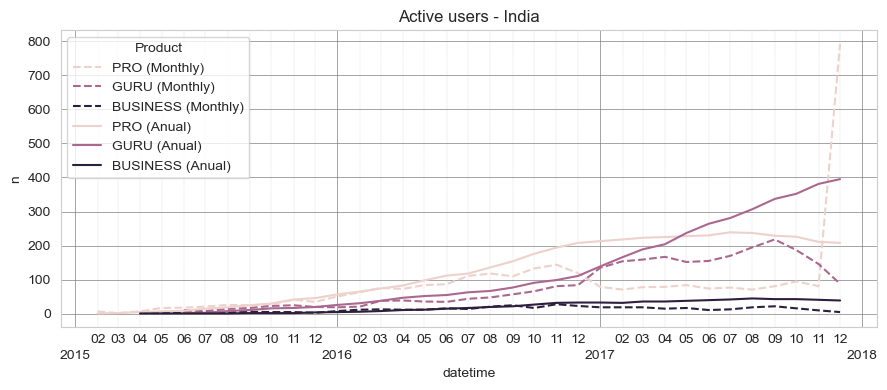

In [20]:
df_time = df_ref.set_index('datetime').groupby([pd.Grouper(freq='MS'), 'billingCountry', 'product', 'period']).size().reset_index().rename(columns={0: 'n'})

df_aux = df_time.loc[df_time['period'] == 1].rename(columns={'n': 'n_monthly'}).drop('period', axis=1)
df_time = df_time.merge(df_aux, on=['datetime', 'billingCountry', 'product'])

df_aux = df_time.loc[df_time['period'] == 12].rename(columns={'n': 'n_anual'}).drop(['period', 'n_monthly'], axis=1)
df_time = df_time.merge(df_aux, on=['datetime', 'billingCountry', 'product'])

df_aux = df_ref.set_index('datetime').groupby([pd.Grouper(freq='MS'), 'billingCountry', 'product']).size().reset_index().rename(columns={0: 'n_tot'})
df_time = df_time.merge(df_aux, on=['datetime', 'billingCountry', 'product'])

df_time['ratio_anual_month'] = df_time['n_anual'] / df_time['n_monthly']

for country in country_order[:]:
    df_aux = df_time.loc[
        (df_time['billingCountry'] == country)
    ]
    
    fig, ax = plt.subplots(figsize=(9,4), dpi=100)
    
    df_plot = df_aux.loc[df_aux['period'] == 1]
    sns.lineplot(data=df_plot, x='datetime', y='n', hue='product', ls='--', palette=color_dict_product, hue_order=product_order, ax=ax)
    
    df_plot = df_aux.loc[df_aux['period'] == 12]
    sns.lineplot(data=df_plot, x='datetime', y='n', hue='product', ls='-', palette=color_dict_product, hue_order=product_order, ax=ax)
    
    plt.title(f"Active users - {country}")
    
    ax = format_ax_date(ax)
    
    handles, labels = ax.get_legend_handles_labels()
    labels[:3] = [f"{x} (Monthly)" for x in labels[:3]]
    labels[3:] = [f"{x} (Anual)" for x in labels[3:]]
    ax.legend(handles, labels, title='Product', loc='best')

    plt.tight_layout()
    plt.show()

> Looking at the data by country, we can again see that UK and US have similar patterns in product usage.

> In France, the drops in monthly active users in PRO and GURU products are similar, while in Canada GURU drops more than PRO

> Again, something happened in INDIA with the PRO Monthly subs

##### _How does revenue in each country and by product change through time?_

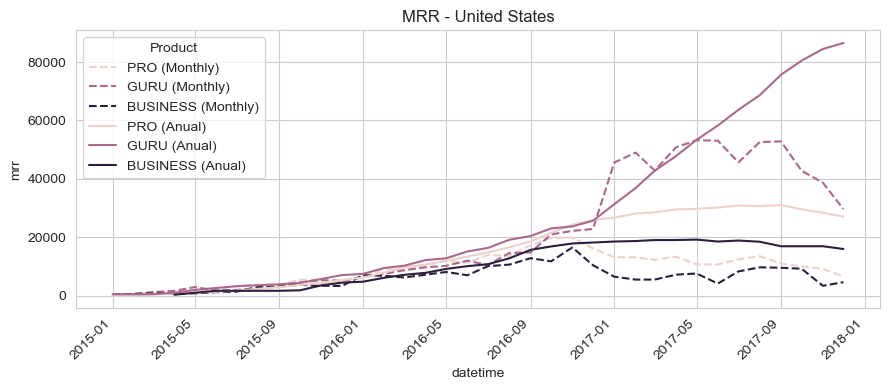

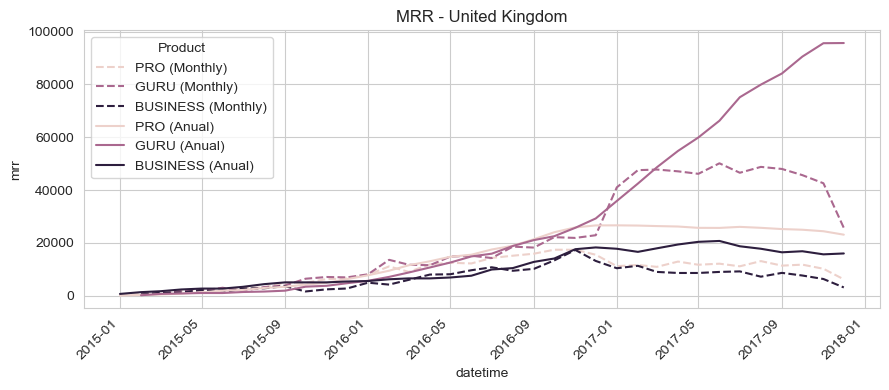

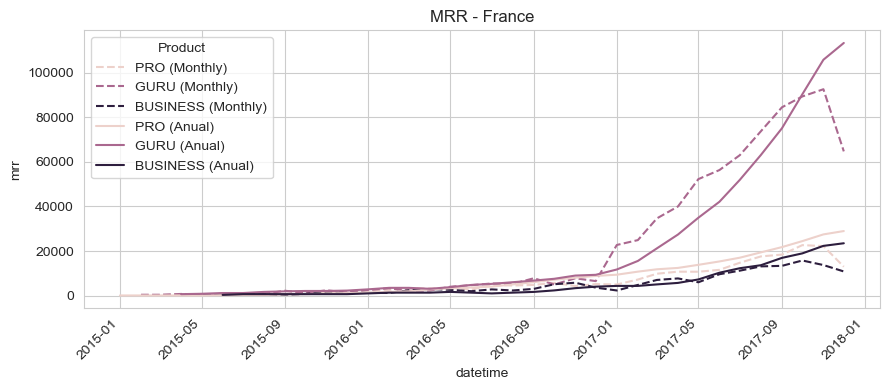

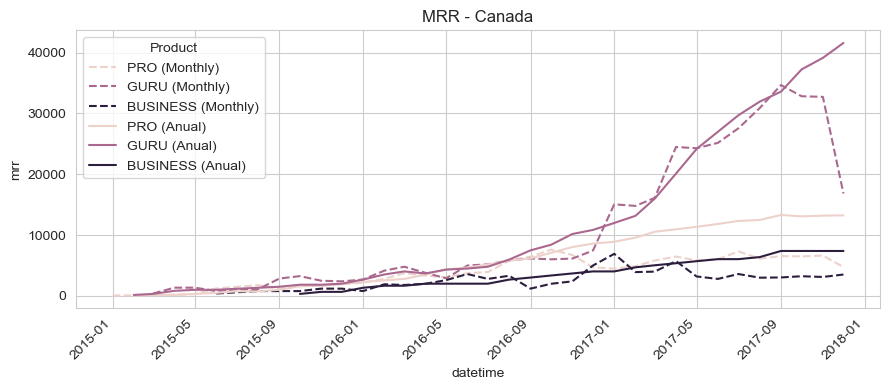

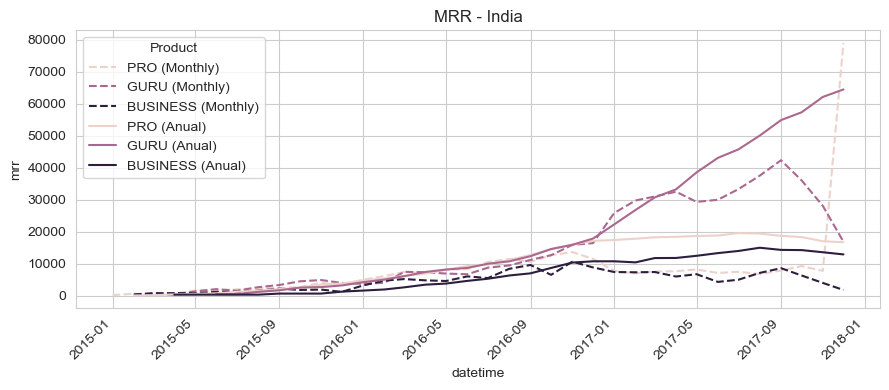

In [21]:
df_time = df_ref.set_index('datetime').groupby([pd.Grouper(freq='MS'), 'billingCountry', 'product', 'period'])['mrr'].sum().reset_index()

for country in country_order[:]:
    df_aux = df_time.loc[
        (df_time['billingCountry'] == country)
    ]
    
    fig, ax = plt.subplots(figsize=(9,4), dpi=100)
    
    df_plot = df_aux.loc[df_aux['period'] == 1]
    sns.lineplot(data=df_plot, x='datetime', y='mrr', hue='product', ls='--', palette=color_dict_product, hue_order=product_order, ax=ax)
    
    df_plot = df_aux.loc[df_aux['period'] == 12]
    sns.lineplot(data=df_plot, x='datetime', y='mrr', hue='product', ls='-', palette=color_dict_product, hue_order=product_order, ax=ax)
    
    plt.xticks(rotation=45, ha='right')
    plt.title(f"MRR - {country}")
    
    
    handles, labels = ax.get_legend_handles_labels()
    labels[:3] = [f"{x} (Monthly)" for x in labels[:3]]
    labels[3:] = [f"{x} (Anual)" for x in labels[3:]]
    ax.legend(handles, labels, title='Product', loc='best')

    plt.tight_layout()
    plt.show()

> As stated before, we can see that annual MRR is a lot higher than monthly.

> Again US and UKL show similar patterns, with a negative slope appearing in anual MRR for PRO and BUSINESS product, with a flattening curve that appears unfavorable in the coming months

> France and Canada both show strong growth in annual GURU product. While Canada has flattened a bit on annual  PRO and BUSINESS products, France shows growth instead.

> India is similar to US and UK in this regard.

#####  What is the most profitable product/period by country?

In [22]:
import matplotlib

def lighten_color(color, amount=0.5):
    try:
        c = matplotlib.colors.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*matplotlib.colors.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

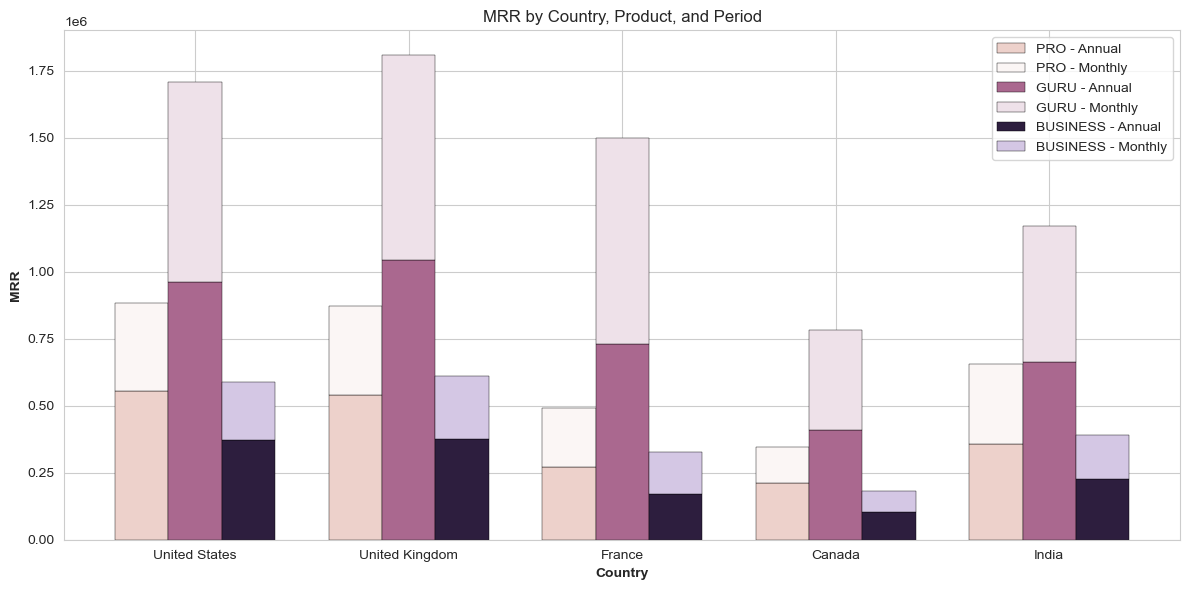

In [23]:
df_plot = df_ref.groupby(['billingCountry', 'product', 'period'])['mrr'].sum().reset_index()
df_plot['period'] = df_plot['period'].map({12: 'period_12', 1: 'period_1'})
pivot_df_plot = df_plot.pivot_table(values='mrr', index=['billingCountry', 'product'], 
                          columns='period', aggfunc='sum', fill_value=0)
if 'period_1' not in pivot_df_plot.columns:
    pivot_df_plot['period_1'] = 0
pivot_df_plot = pivot_df_plot.reset_index()

# Sort the DataFrame based on the country_order
pivot_df_plot['country_order'] = pivot_df_plot['billingCountry'].map({country: i for i, country in enumerate(country_order)})
pivot_df_plot = pivot_df_plot.sort_values('country_order')

fig, ax = plt.subplots(figsize=(12, 6))
barWidth = 0.25

# Use the sorted unique countries for positioning
unique_countries = pivot_df_plot['billingCountry'].unique()
r1 = np.arange(len(unique_countries))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

for i, product in enumerate(product_order):
    data = pivot_df_plot[pivot_df_plot['product'] == product]
    positions = [r1, r2, r3][i]
    color = color_dict_product.get(product, '#333333')
    light_color = lighten_color(color, 0.2)
    
    p12 = ax.bar(positions, data['period_12'], width=barWidth, color=color, label=f"{product} - Annual", edgecolor='black')
    p1 = ax.bar(positions, data['period_1'], width=barWidth, bottom=data['period_12'], color=light_color, label=f"{product} - Monthly", edgecolor='black')

plt.xlabel('Country', fontweight='bold')
plt.ylabel('MRR', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(unique_countries))], unique_countries)
plt.setp(ax.patches, linewidth=0.3)
plt.legend()
plt.title('MRR by Country, Product, and Period')
plt.tight_layout()
plt.show()

> US and UK again very similar

> France is a close third in terms of revenue

> Canada lags behind

> India has the proportion of revenue in pro product almost 1:1, while the rest are more 1:2

# User behaviour

In [24]:
df_exploded, df_org = load_and_clean()

Loading and cleaning data..
Done.


In [25]:
df_ref = df_exploded.copy()
df_ref['datetime'] = df_ref['mrr_month']

In [26]:
df_min = df_ref.groupby(['userId']).min().reset_index()[['userId', 'datetime']].rename(columns={'datetime': 'first_transaction'})
df_max = df_ref.groupby(['userId']).max().reset_index()[['userId', 'datetime']].rename(columns={'datetime': 'last_transaction'})
df_n_transactions = df_ref.groupby(['userId']).size().reset_index().rename(columns={0: 'n_transactions'})
df_n_types_subs = df_ref.groupby(['userId'])['period'].nunique().reset_index().rename(columns={'period': 'n_type_subs'})
df_n_types_prods = df_ref.groupby(['userId'])['product'].nunique().reset_index().rename(columns={'product': 'n_type_prods'})
df_country = df_ref.groupby(['userId']).head(1)[['userId', 'billingCountry']]
df_users = (
    df_min
    .merge(df_max, on='userId')
    .merge(df_n_transactions, on='userId')
    .merge(df_n_types_subs, on='userId')
    .merge(df_n_types_prods, on='userId')
    .merge(df_country, on='userId')
)

##### _How products does the user have on average?_

In [27]:
df_users['n_type_prods'].value_counts(normalize=True).reset_index()

,n_type_prods,proportion
0,1,0.857684
1,2,0.133446
2,3,0.008870


> On average, 85% have only 1 product

##### _Does this change by country?_

In [28]:
(
    df_users
    .groupby(['billingCountry'])['n_type_prods']
    .value_counts(normalize=True)
    .reset_index()
    .pivot_table(index='billingCountry', columns=['n_type_prods'], values=['proportion'])
    .sort_values(by=('proportion', 1))
)

proportion                    
n_type_prods            1         2         3
billingCountry                               
United Kingdom   0.822672  0.165273  0.012055
United States    0.824184  0.165071  0.010744
Canada           0.858911  0.134488  0.006601
India            0.863828  0.125877  0.010295
France           0.916545  0.079438  0.004018

> It seems that UK ans US seem a bit more 'active' that he rest of the countries as over time, 17% of users have had at least 2 products, which is quite higher than the rest of the countries.

##### _How long does the user stay subbed?_

In [29]:
def detect_changes(group):
    changes = group['value'].ne(group['value'].shift())
    changes.iloc[0] = False
    
    return changes

def calculate_continuity(df):
    df = df.sort_values(['userId', 'datetime'])
    
    df['datetime_day_start'] = pd.to_datetime(df['datetime'].dt.date)
    df['datetime_day_end'] = df.apply(lambda row: (df['datetime_day_start'][row.name] + pd.DateOffset(months=int(row['period']))).date(), axis=1)
    df['datetime_day_end'] = pd.to_datetime(df['datetime_day_end'])
    
    df['next_start'] = df.groupby('userId')['datetime_day_start'].shift(-1)
    df['prev_end'] = df.groupby('userId')['datetime_day_end'].shift(1)
    
    df['b_continuity'] = (
        (df['datetime_day_start'] == df['prev_end']).astype(int)
        | (df['datetime_day_end'] == df['next_start']).astype(int)
    )
    
    df['starter'] = (
        (df['b_continuity'] == 0) | 
        (df.groupby('userId')['b_continuity'].cumcount() == 0) |
        (df['datetime_day_start'] != df['prev_end'])
    ).astype(int)
    
    df['ender'] = (
        (df['b_continuity'] == 0) | 
        (df.groupby('userId')['b_continuity'].cumcount() == df.groupby('userId')['b_continuity'].transform('count') - 1) |
        (df['datetime_day_end'] != df['next_start'])
    ).astype(int)

    df['sequence'] = ((df['starter'] == 1) | (df['userId'] != df['userId'].shift())).cumsum()
    
    df['duration_sequence'] = df.groupby('sequence')['sequence'].transform('count')
    
    mask = df['ender'] == 1
    df.loc[mask, 'time_til_next_start'] = (df.loc[mask]['next_start'] - df.loc[mask]['datetime_day_end']).dt.days
    
    df['duration_months'] = df.groupby('sequence')['period'].transform('sum')
    df['n_sequences'] = df.groupby('userId')['sequence'].transform('nunique')
        
    # product
    df['product_start'] = df.groupby('sequence')['product'].transform('first')
    df['product_end'] = df.groupby('sequence')['product'].transform('last')
    
    df['product_changed'] = (df['product'] != df.groupby('sequence')['product'].shift()).fillna(True)
    df['prod_change_counter'] = df.groupby('sequence')['product_changed'].cumsum()
    df['sequence_prod'] = df['sequence'] * 1000 + df['prod_change_counter']
    df['n_sequences_prod'] = df.groupby(['userId', 'sequence'])['prod_change_counter'].transform('nunique')
    df['duration_months_prod'] = df.groupby(['userId', 'sequence_prod'])['period'].transform('sum')
    

    # Detect changes
    def detect_changes(group):
        changes = group['sequence_prod'].ne(group['sequence_prod'].shift())
        changes.iloc[0] = False
        return changes

    # Apply the function to each group
    df['change_detected'] = (df.groupby(['userId', 'sequence']).apply(detect_changes).reset_index(level=[0,1], drop=True)).astype(int)
    
    df['duration_months_prod_prev'] = df.groupby(['userId', 'sequence'])['duration_months_prod'].shift(+1)
    df['duration_months_prod_prev'] = (df['duration_months_prod_prev'] * df['change_detected']).fillna(0)

    
    return df

In [30]:
'''
This function lets us calculate the 'sequences' of subscriptions per user. We can detect which product started a sequence, which product ended it, how many days elapsed before a re-sub, etc.
Below are some examples (commented)
'''


df_ref = df_org.copy()
df_continuity = calculate_continuity(df_ref)

In [31]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

'''
 Examples
'''

# df_continuity.loc[df_continuity['userId'] == 153]

# df_continuity.loc[df_continuity['userId'] == 98643]

# df_continuity.loc[df_continuity['userId'] == 349]

# df_continuity.loc[df_continuity['userId'] == 98811]

'\n Examples\n'

In [32]:
df_continuity

,userId,billingCountry,transactionTime,product,price,amount,period,datetime,datetime_day_start,datetime_day_end,next_start,prev_end,b_continuity,starter,ender,sequence,duration_sequence,time_til_next_start,duration_months,n_sequences,product_start,product_end,product_changed,prod_change_counter,sequence_prod,n_sequences_prod,duration_months_prod,change_detected,duration_months_prod_prev
3345,2,United States,1456118396,GURU,199.99,2015.90,12,2016-02-22 05:19:56,2016-02-22,2017-02-22,NaT,NaT,0,1,1,1,1,NaN,12,1,GURU,GURU,True,1,1001,1,12,0,0.0
1414,13,United Kingdom,1444875806,GURU,199.99,199.99,1,2015-10-15 02:23:26,2015-10-15,2015-11-15,NaT,NaT,0,1,1,2,1,NaN,1,1,GURU,GURU,True,1,2001,1,1,0,0.0
6657,18,United Kingdom,1467556809,PRO,99.99,49.99,1,2016-07-03 14:40:09,2016-07-03,2016-08-03,NaT,NaT,0,1,1,3,1,NaN,1,1,PRO,PRO,True,1,3001,1,1,0,0.0
31439,29,France,1506638372,GURU,199.99,199.99,1,2017-09-28 22:39:32,2017-09-28,2017-10-28,NaT,NaT,0,1,1,4,1,NaN,1,1,GURU,GURU,True,1,4001,1,1,0,0.0
13582,33,United Kingdom,1482921892,PRO,99.99,99.99,1,2016-12-28 10:44:52,2016-12-28,2017-01-28,2017-09-28,NaT,0,1,1,5,1,243.0,1,2,PRO,PRO,True,1,5001,1,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37853,210470,India,1514164197,PRO,99.99,99.99,1,2017-12-25 01:09:57,2017-12-25,2018-01-25,NaT,NaT,0,1,1,25866,1,NaN,1,1,PRO,PRO,True,1,25866001,1,1,0,0.0
38133,210792,India,1514164605,PRO,99.99,99.99,1,2017-12-25 01:16:45,2017-12-25,2018-01-25,NaT,NaT,0,1,1,25867,1,NaN,1,1,PRO,PRO,True,1,25867001,1,1,0,0.0
37924,210873,India,1514164306,PRO,99.99,99.99,1,2017-12-25 01:11:46,2017-12-25,2018-01-25,NaT,NaT,0,1,1,25868,1,NaN,1,1,PRO,PRO,True,1,25868001,1,1,0,0.0
37580,210891,India,1514163872,PRO,99.99,99.99,1,2017-12-25 01:04:32,2017-12-25,2018-01-25,NaT,NaT,0,1,1,25869,1,NaN,1,1,PRO,PRO,True,1,25869001,1,1,0,0.0


In [33]:
# All products and periods
df_avg_duration = df_continuity[['userId', 'sequence', 'product_start', 'duration_months']].groupby(['userId', 'sequence', 'product_start']).mean().reset_index()
df_avg_duration.groupby(['product_start'])['duration_months'].mean().reset_index()

,product_start,duration_months
0,BUSINESS,4.392899
1,GURU,4.029436
2,PRO,4.255737


> We can see that taking the average of all products doesn't seem to tell us a lot

In [34]:
# Filtering by monthly
df_avg_duration = df_continuity.loc[df_continuity['period'] == 1][['userId', 'sequence', 'product_start', 'duration_months']].groupby(['userId', 'sequence', 'product_start']).mean().reset_index()
df_avg_duration.groupby(['product_start'])['duration_months'].mean().reset_index()

,product_start,duration_months
0,BUSINESS,2.354908
1,GURU,1.994277
2,PRO,2.210403


> Separating the users that sub monthly doesn't give us a lot of insight either. The average time a monthly stays subbed is around 2 months

_What's the distribution?_

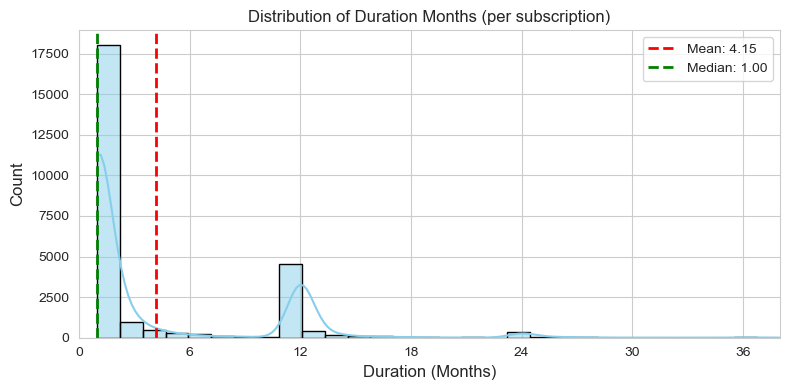

In [35]:
df_avg_duration = df_continuity[['userId', 'sequence', 'product_start', 'duration_months']].groupby(['userId', 'sequence', 'product_start']).mean().reset_index()

sns.set_style("whitegrid")
plt.figure(figsize=(8, 4))

ax = sns.histplot(data=df_avg_duration, x='duration_months', kde=True, 
                  bins=30, color='skyblue', edgecolor='black')

mean_duration = df_avg_duration['duration_months'].mean()
plt.axvline(mean_duration, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_duration:.2f}')

median_duration = df_avg_duration['duration_months'].median()
plt.axvline(median_duration, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_duration:.2f}')

plt.title('Distribution of Duration Months (per subscription)', fontsize=12)
plt.xlabel('Duration (Months)', fontsize=12)
plt.ylabel('Count', fontsize=12)

max_duration = df_avg_duration['duration_months'].max()
plt.xlim(0, max_duration)
plt.xticks(np.arange(0, max_duration+1, 6))

plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

> We can see obious peaks in 1, 12 and 24 months

_What's the threshold for 1 month?_

In [36]:
def find_threshold_percentile(data, threshold=1):
    percentiles = np.arange(0, 101)
    values = np.percentile(data, percentiles)
    threshold_percentile = percentiles[values > threshold][0]
    return threshold_percentile

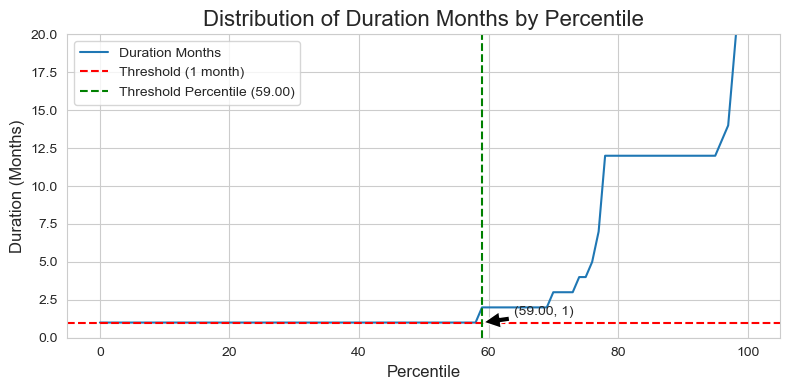

The value exceeds 1 at the 59.00th percentile.


In [37]:
data = df_avg_duration['duration_months']

percentiles = np.arange(0, 101)
duration_percentiles = np.percentile(data, percentiles)

threshold_percentile = find_threshold_percentile(data)

plt.figure(figsize=(8, 4))
sns.set_style("whitegrid")

plt.plot(percentiles, duration_percentiles, label='Duration Months')
plt.axhline(y=1, color='r', linestyle='--', label='Threshold (1 month)')
plt.axvline(x=threshold_percentile, color='g', linestyle='--', 
            label=f'Threshold Percentile ({threshold_percentile:.2f})')

plt.title('Distribution of Duration Months by Percentile', fontsize=16)
plt.xlabel('Percentile', fontsize=12)
plt.ylabel('Duration (Months)', fontsize=12)
plt.legend(fontsize=10)

plt.annotate(f'({threshold_percentile:.2f}, 1)', 
             xy=(threshold_percentile, 1), 
             xytext=(threshold_percentile+5, 1.5),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.ylim(0, min(duration_percentiles.max(), 20))  # Limit y-axis for better visibility
plt.tight_layout()
plt.show()

print(f"The value exceeds 1 at the {threshold_percentile:.2f}th percentile.")

> 60% of subscriptions last 1 month

_How many users switch products mid-cycle?_

In [38]:
(
    (df_continuity[['userId', 'n_sequences_prod']]
	.groupby(['userId'])
	.max()['n_sequences_prod']
	.value_counts(normalize=True) * 100)
	.reset_index()
)

,n_sequences_prod,proportion
0,1,92.458549
1,2,6.422713
2,3,0.909253
3,4,0.182742
4,5,0.026743


> 92% of subscriptions consist of one single product

_What is the most common switch for the people that do switch?_

In [39]:
df_prod_changes = (
    df_continuity
    .loc[df_continuity['n_sequences_prod'] > 1]
    .groupby(['userId', 'sequence_prod'])
    .head(1)[['userId', 'product']]
    .groupby(['userId'])['product']
    .apply(list)
    .reset_index()
    .rename(columns={'product': 'product_history'})
)

(df_prod_changes['product_history'].value_counts(normalize=True) * 100).reset_index().head(10)

,product_history,proportion
0,"[PRO, GURU]",39.598109
1,"[GURU, PRO]",26.004728
2,"[BUSINESS, GURU]",5.673759
3,"[BUSINESS, PRO]",4.846336
4,"[PRO, BUSINESS]",4.432624
5,"[GURU, PRO, GURU]",4.078014
6,"[GURU, BUSINESS]",3.132388
7,"[PRO, GURU, PRO]",2.777778
8,"[PRO, GURU, PRO, GURU]",1.182033
9,"[GURU, BUSINESS, GURU]",0.768322


> We can see that the most common occurence when switching is from PRO to GURU (40% of cases) with GURU to PRO being second with 26%.

> A lot of other combinations are possible but volumne is too low to seem relevant to the study.

_How long does it take for them to switch?_

In [40]:
df_target = df_prod_changes.loc[
    df_prod_changes['product_history'].isin(
        [['PRO', 'GURU'], ['GURU', 'PRO']]
    )
]

df_aux = df_target.merge(df_continuity, on='userId').sort_values(by=['userId', 'datetime'])
df_aux = df_aux.loc[
    (df_aux['n_sequences_prod'] > 1)
    & (df_aux['change_detected'] == 1)
]
tmp_avg = df_aux['duration_months_prod_prev'].mean()
print(f"Global avg: {tmp_avg:.2f}")

Global avg: 2.74


In [41]:
df_aux.groupby(['product_start'])['duration_months_prod_prev'].mean().reset_index()

,product_start,duration_months_prod_prev
0,GURU,2.061364
1,PRO,3.192537


> On average, it takes a 'switcher' to move from one type of subscription to another 2.7 months.

> Discriminating by starter product, we can see that this average is lower for GURU and for PRO.

_How long does it take them to re-sub?_

In [42]:
df_avg_resub = df_continuity.loc[
    (df_continuity['n_sequences'] > 1)
    & (df_continuity['time_til_next_start'].notnull())
]
tmp_avg = df_avg_resub['time_til_next_start'].mean()
print(f"Global avg: {tmp_avg:.2f}")
df_avg_resub[['product_start', 'time_til_next_start']].groupby(['product_start']).mean()[['time_til_next_start']]

Global avg: 272.12


,time_til_next_start
product_start,
BUSINESS,294.385666
GURU,248.195122
PRO,285.706397


> It takes on average 272 days for a user to resub to a product. It takes a bit less if the first product was 'GURU'